In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, optimize, stats, signal
import matplotlib.pyplot as plt

In [2]:
scale = 1e5

In [3]:
def GRM_ODE(t, C, r, p, K, a):
    return r*(np.power(C*scale, p)/scale)*(1-np.power(((C*scale)/(K*scale)), a))

In [4]:
def GRM(t, C0, r, p, K, a, rtol=1e-6):
    return integrate.solve_ivp(GRM_ODE, (t[0], t[-1]), [C0], t_eval=t, args=(r, p, K, a), rtol=rtol).y[0]

In [5]:
data = pd.read_json("https://epistat.sciensano.be/Data/COVID19BE_CASES_AGESEX.json")
data["DATE"] = pd.to_datetime(data["DATE"])

In [6]:
cases = data.groupby("DATE")["CASES"].sum().to_frame()
cases["index"] = (cases.index - cases.index[0])//pd.Timedelta("1d")
cases["cumsum"] = cases["CASES"].cumsum()
cases = cases.reset_index().rename(columns={"CASES": "daily", "DATE": "date"}).set_index("date")
cases["cs_mv14d"] = cases["cumsum"].rolling(14).mean().shift(-7)
cases["d_mv14d"] = cases["cs_mv14d"].diff()
cases["cs_savgol"] = signal.savgol_filter(cases["cumsum"], 31, 7)
cases["d_savgol"] = cases["cs_savgol"].diff()
cases.to_csv("covid.csv", index=False)
cases.sample(10)

,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol
date,,,,,,,
2021-01-18,2936,323,682014,6.836801e+05,2012.214286,6.823926e+05,2009.709236
2020-09-11,1284,194,94291,9.501786e+04,1099.214286,9.377251e+04,1062.548251
2020-11-05,7644,249,496905,4.930809e+05,7357.928571,4.947891e+05,6704.339448
2021-10-01,2149,579,1242232,1.242581e+06,1996.357143,1.241507e+06,1970.732996
2021-06-09,841,465,1071162,1.070987e+06,774.285714,1.071158e+06,777.490544
2020-05-13,321,73,55431,5.543586e+04,310.571429,5.542926e+04,297.014308
2021-12-02,18329,641,1831334,1.830800e+06,15792.928571,1.826913e+06,16429.156464
2020-04-14,1560,44,36524,3.740579e+04,1302.500000,3.716945e+04,1279.666243
2020-05-02,286,62,51048,5.131700e+04,445.214286,5.107849e+04,394.939667


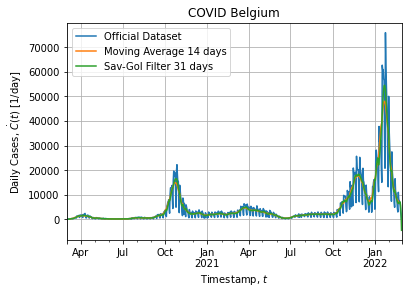

In [7]:
axe = cases["daily"].plot(label="Official Dataset")
cases["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

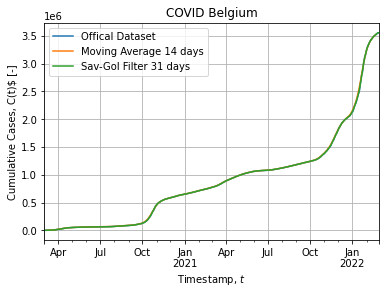

In [8]:
axe = cases["cumsum"].plot(label="Offical Dataset")
cases["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
cases["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.set_yscale("linear")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, C(t)$ [-]")
axe.grid()

In [9]:
t0 = "2021-12-21"
t1 = "2022-02-21"

In [10]:
peak = cases.loc[(cases.index >= t0) & (cases.index < t1), :]
for k in ["index", "cumsum", "cs_mv14d", "cs_savgol"]:
    peak[k + "_origin"] = peak[k] - peak[k][0]
peak.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,daily,index,cumsum,cs_mv14d,d_mv14d,cs_savgol,d_savgol,index_origin,cumsum_origin,cs_mv14d_origin,cs_savgol_origin
date,,,,,,,,,,,
2022-02-14,16480,715,3467172,3.468605e+06,10577.428571,3.468721e+06,11067.485355,55,1439701,1.437221e+06,1.442333e+06
2022-01-12,31148,682,2395313,2.420567e+06,32646.071429,2.385713e+06,27581.681752,22,367842,3.891830e+05,3.593259e+05
2022-01-22,32788,692,2824251,2.846123e+06,47993.714286,2.826034e+06,54535.595538,32,796780,8.147387e+05,7.996467e+05
2022-01-23,20747,693,2844998,2.893989e+06,47866.142857,2.879585e+06,53550.825858,33,817527,8.626049e+05,8.531975e+05
2022-01-01,4070,671,2129869,2.156552e+06,16554.785714,2.136780e+06,16254.299426,11,102398,1.251675e+05,1.103924e+05


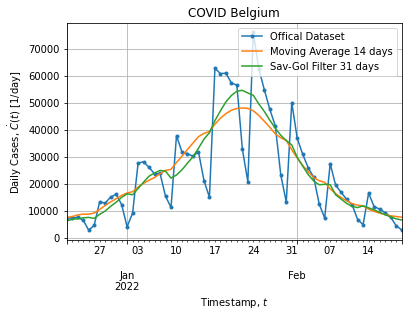

In [11]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset")
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

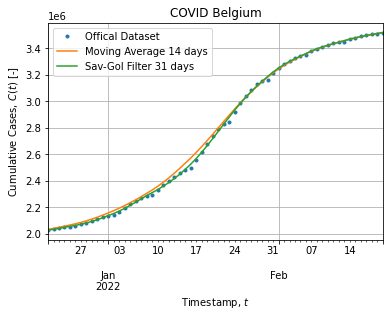

In [12]:
axe = peak["cumsum"].plot(marker=".", linestyle="none", label="Offical Dataset")
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days")
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days")
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Cumulative Cases, $C(t)$ [-]")
axe.grid()

<AxesSubplot:xlabel='index_origin'>

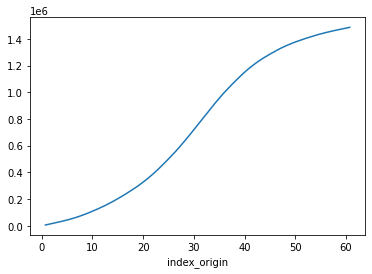

In [13]:
def resample(frame):
    sample = frame.copy()
    # Reindex:
    sample = frame.set_index("index_origin")
    index = np.arange(sample.index.min(), sample.index.max() + 0.001, 0.25)
    sample = sample.reindex(index).interpolate().reset_index()
    # Resample:
    sample = sample.sample(frac=1.0, replace=True).sort_index()
    # Deduplicate + Counts:
    count = sample.groupby(sample.index)["index"].count()
    count.name = "count"
    sample = sample.drop_duplicates().merge(count, left_index=True, right_index=True)
    sample = sample.sort_index()
    sample["sigma"] = np.sqrt(1/sample["count"])
    return sample
r = resample(peak)
r.set_index("index_origin")["cs_mv14d_origin"].plot()

In [14]:
np.random.seed(123456789)

In [ ]:
params = []
for i in range(200):
    # Resampling:
    sample = resample(peak)
    print(i, sample.shape[0])
    # Adjusting:
    popt, pcov = optimize.curve_fit(
        GRM,
        sample["index_origin"].values, sample["cs_mv14d_origin"].values/scale, sigma=sample["sigma"].values,
        p0=(2.2e4/scale, 1.0, 0.75, 1.5e6/scale, 2.1),
        bounds=([1/scale, 1e-2, 1e-2, 50/scale, 0.1], [1e5/scale, 10, 1, 1e7/scale, 10]),
        gtol=1e-9, max_nfev=25000
    )
    params.append(popt)
params = pd.DataFrame(params, columns=["C", "r", "p", "K", "a"])
params.to_csv("bootstrap.csv", index=False)

In [16]:
#params = pd.read_csv("bootstrap_02.csv")

In [23]:
params.sample(5)

,C,r,p,K,a
104,0.186780,3.676054,0.716270,15.026886,2.077486
29,0.173229,4.046003,0.708344,15.038769,2.117318
63,0.184692,3.830033,0.712952,15.018248,2.096880
176,0.187921,3.823041,0.713017,15.052688,2.076168
39,0.138870,7.075447,0.662823,14.861266,2.489982


In [24]:
stats = params.describe()
stats

,C,r,p,K,a
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.171240,4.505620,0.701244,15.018791,2.150707
std,0.017979,0.826521,0.015391,0.033727,0.098592
min,0.138870,2.367213,0.662823,14.861266,1.864016
25%,0.158774,3.971907,0.691178,14.996894,2.087186
50%,0.167787,4.482746,0.700196,15.020275,2.153577
75%,0.179839,5.014200,0.710262,15.041674,2.213822
max,0.253731,7.075447,0.752381,15.114152,2.489982


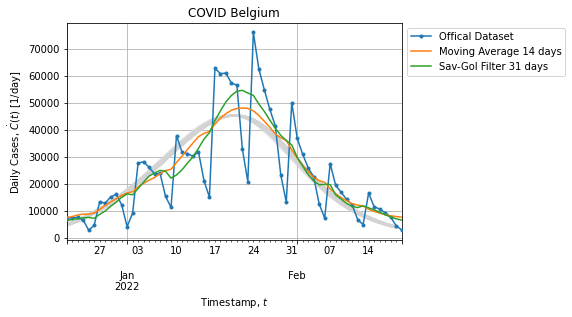

In [25]:
axe = peak["daily"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale
    axe.plot(peak.index[:-1], np.diff(c), color="lightgrey", linewidth=0.6)
c = GRM(peak["index"], *popt)
#axe.plot(peak.index[:-1], np.diff(c), "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["d_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["d_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend(bbox_to_anchor=(1,1), loc="upper left")
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

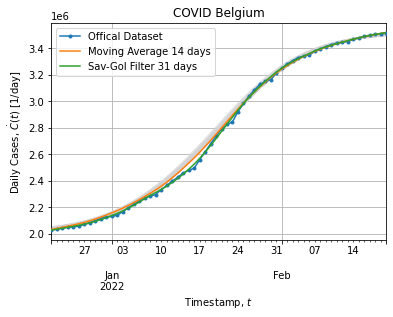

In [20]:
fig, axe = plt.subplots()
peak["cumsum"].plot(linestyle="-", marker=".", label="Offical Dataset", zorder=1000)
for row in params.itertuples():
    c = GRM(peak["index"], *row[1:])*scale + peak["cumsum"][0]
    axe.plot(peak.index, c, color="lightgrey", linewidth=0.6)
c = GRM(peak["index"], *popt) + peak["cumsum"][0]
#axe.plot(peak.index, c, "-.", color="red", linewidth=1.35, label="Single Fit", zorder=2000)
peak["cs_mv14d"].plot(ax=axe, label="Moving Average 14 days", zorder=1001)
peak["cs_savgol"].plot(ax=axe, label="Sav-Gol Filter 31 days", zorder=1002)
axe.legend()
axe.set_title("COVID Belgium")
axe.set_xlabel(r"Timestamp, $t$")
axe.set_ylabel(r"Daily Cases, $\dot{C}(t)$ [1/day]")
axe.grid()

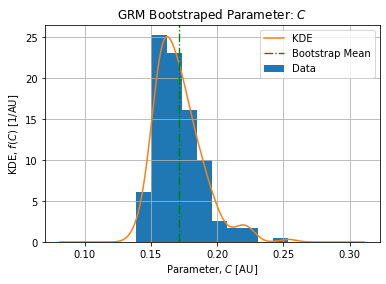

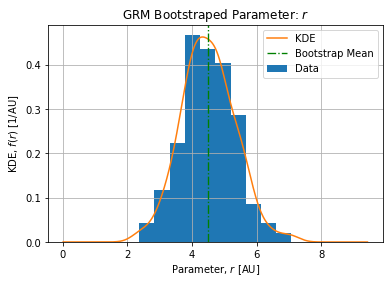

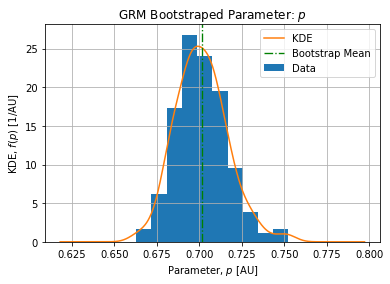

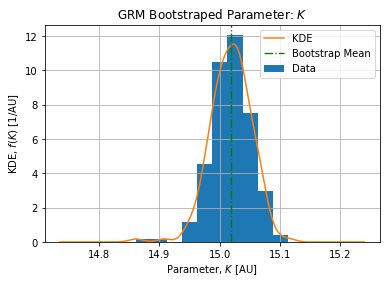

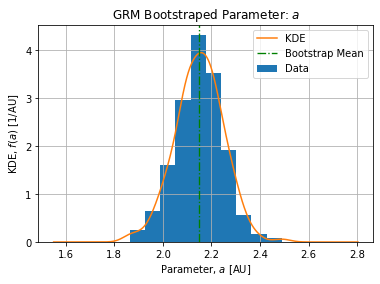

In [26]:
xm = params.mean()
for i, k in enumerate(params):
    fig, axe = plt.subplots()
    params[k].plot(kind="hist", ax=axe, label="Data", density=1)
    params[k].plot(kind="kde", ax=axe, label="KDE")
    axe.axvline(xm[i], linestyle="-.", color="green", linewidth=1.35, label="Bootstrap Mean")
    #axe.axvline(popt[i], linestyle="-.", color="red", linewidth=1.35, label="Single Fit")
    axe.legend()
    axe.set_title(r"GRM Bootstraped Parameter: $%s$" % k)
    axe.set_xlabel(r"Parameter, $%s$ [AU]" % k)
    axe.set_ylabel(r"KDE, $f(%s)$ [1/AU]" % k)
    axe.grid()

In [27]:
stats.loc["std",:]/stats.loc["mean",:]

C    0.104995
r    0.183442
p    0.021949
K    0.002246
a    0.045842
dtype: float64